In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Clean data just like ProPublica did. 

In [2]:
raw = pd.read_csv('data/compas-scores-two-years.csv')
d = raw[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 
         'juv_fel_count','juv_misd_count','juv_other_count',
                    'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
d = d[(d.days_b_screening_arrest >= -30) & 
      (d.days_b_screening_arrest <= 30) & 
      (d.is_recid != -1) & 
      (d.c_charge_degree != 'O') & 
      (d.score_text != 'N/A')]

In [3]:
raw.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

The first thing to think about is what COMPAS customers would have seen if they'd seen the tool without a chance to assess the training data or test it out in a real deployment. This is probably the worst possible situation for a customer to be in, but it's not unrealistic. Start by plotting `decile_score` for the different racial groups.

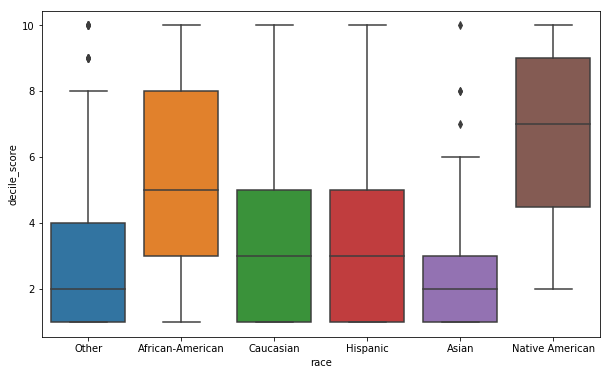

In [4]:
X1 = d[['race','decile_score']]
plt.rcParams["figure.figsize"] = [10,6]
sns.boxplot(x='race',y='decile_score',data=X1)

*TODO:* Insert discussion of individual and group fairness

*TODO:* I can make a nicer-looking plot in R. A scatterplot with jitter would do a better job of conveying the imbalance in the number of instances in each group.

From this simple plot, it's clear that the COMPAS model falls flat on _group_ fairness -- African-Americans and Native Americans are consistently labeled as higher-risk than those of other races. To assess whether it does better on individual fairness, we'll need to evaluate the model's performance out-of-sample. We'll do this by looking at the `two_year_recid` variable and using some of Yellowbrick's model evaluation routines.

In [58]:
from sklearn.base import BaseEstimator, ClassifierMixin

class Identity(BaseEstimator, ClassifierMixin):
    def fit(self, X, y=None):
        return self 
    def predict(self, X):
        if X.ndim > 1:
            raise ValueError("pass through, provide y_true!")
        return X 
    def predict_proba(self, X):
        if X.ndim > 1:
            raise ValueError("pass through, provide y_true!")
        Xr = X.values.reshape(-1,1)
        Xinv = (1.0 - X).values.reshape(-1,1)
        return np.concatenate([Xr,Xinv],axis=1)

First, look at the Classification Report for the entire population

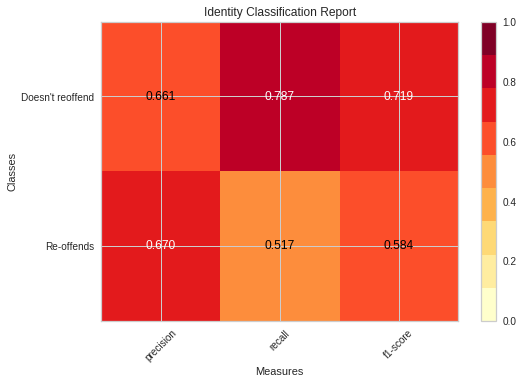

In [6]:
from yellowbrick.classifier import ClassificationReport
X2 = (d['decile_score'] > 5).astype(int)
y2 = d['two_year_recid']

viz2 = ClassificationReport(Identity(),classes=['Doesn\'t reoffend','Re-offends'])
viz2.fit(X2,y2)
viz2.score(X2,y2)
viz2.poof()

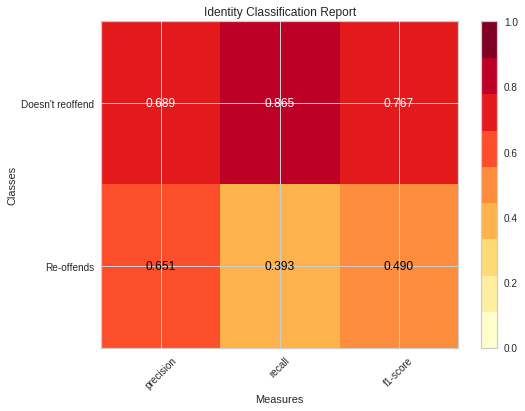

In [7]:
def race_cr(racestr):
    race_sel = d['race'] == racestr
    X = (d['decile_score'] > 5).astype(int)[race_sel]
    y = d['two_year_recid'][race_sel]
    viz = ClassificationReport(Identity(),classes=['Doesn\'t reoffend','Re-offends'])
    viz.fit(X,y)
    viz.score(X,y)
    viz.poof()

plt.rcParams["figure.figsize"] = [8,6]
race_cr('Caucasian')

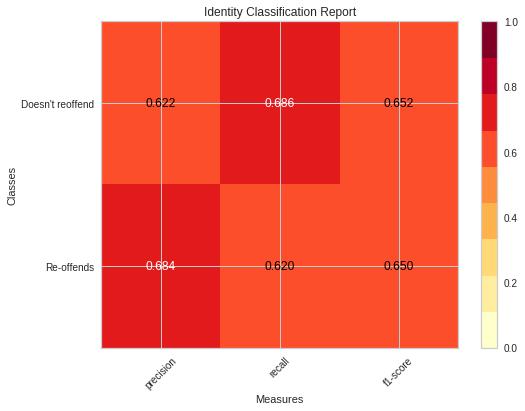

In [8]:
race_cr('African-American')

From the R analysis, we know that we have a higher false negative rate for Caucasians, and a higher false positive rate for African-Americans. We also know that African-Americans have a higher overall recidivism rate, along with a lower true-negative rate and a higher true-positive rate. Here, we see that accuracy is balanced across the different classes very differently for the two groups -- for Caucasians, the model performs better for reoffenders, while for African-Americans errors are more evenly balanced across the two classes.

_Precision_ is defined as TP/(TP + FP). In the case of re-offenders, this is the fraction of those predicted to re-offend by the algorithm who actually did. Comparing positive predictions of re-offense, this measure is slightly higher for African-Americans than for Caucasians, as their true and false positive rates are both higher. 

_Recall_ is defined as TP/(TP + FN) - the fration of those who really did reoffend who were predicted to re-offend by the algorithm. Here there is a much larger racial disparity. Caucasians have a lower TP and a higher FN rate than African-Americans. 

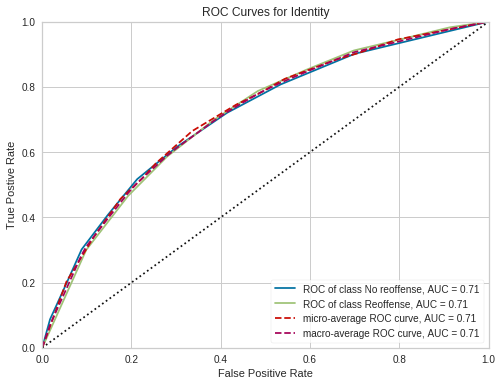

In [65]:
from yellowbrick.classifier import ROCAUC

X3 = (d['decile_score']-1)/9 # make look like a probability
y3 = 1-d['two_year_recid']

viz3 = ROCAUC(Identity(),classes=['No reoffense','Reoffense'])
viz3.fit(X3,y3)
viz3.score(X3,y3)
viz3.poof()

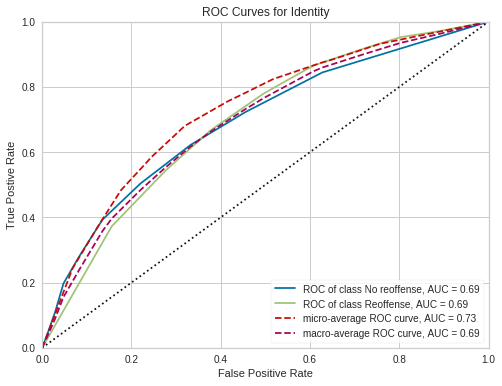

In [76]:
def race_roc(racestr):
    race_sel = d['race'] == racestr
    X = ((d['decile_score']-1)/9)[race_sel]
    y = (1 - d['two_year_recid'])[race_sel]
    viz = ROCAUC(Identity(),classes=['No reoffense','Reoffense'])
    viz.fit(X,y)
    viz.score(X,y)
    viz.poof()

race_roc('Caucasian')

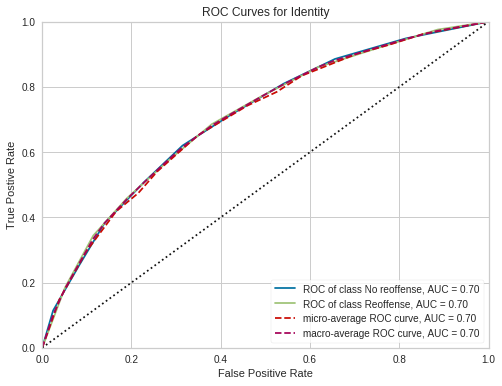

In [70]:
race_roc('African-American')

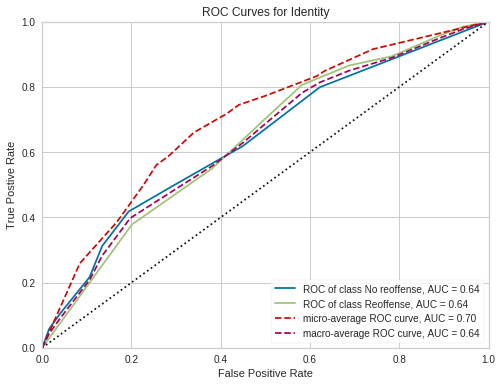

In [72]:
race_roc('Hispanic')